# **STANDARD NOTEBOOK TO GET RESULTS**

## 1. Clean the Data

In [8]:
import pandas as pd 
import numpy as np 
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv(r'/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.fillna(0) # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

df_cleaned = df_cleaned.transpose() ## WE WANT COLUMNS TO BE VECTOR OF RETURN FOR A GIVEN TICKER

## 4. Get SP500 data for comparison

In [9]:
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier

def naive_portfolio(df_cleaned, timeframe):

    ## on calcule le rendement d'un portefeuille dans lequel chaque actif a un poids uniforme
    naive_portfolio_res = df_cleaned.mul(1/len(df_cleaned.columns)).sum(axis=1)[timeframe[0]:timeframe[1]]

    return naive_portfolio_res

def cumulative_returns(portfolio):

    # Compute cumulative returns
    cumulative_returns_res = (1 + portfolio).cumprod()

    return cumulative_returns_res

def plot_long_only(cumulative_returns, timeframe):

    # Multiply the cumulative returns by the initial investment
    initial_investment = 1
    portfolio_value = initial_investment * cumulative_returns

    # Generate date range
    start_date = timeframe[0]
    end_date = timeframe[1]
    dates = pd.date_range(start=start_date, end=end_date, periods=5279)

    # Plot the evolution of the portfolio value
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_value, color='blue', linestyle='-', linewidth=0.7, label='Portfolio Value')  # Adjust appearance here
    plt.title('Evolution of Long-Only Portfolio Strategy (2000-2020)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')

    # Customize x-axis ticks and labels
    plt.xticks(pd.date_range(start=start_date, end=end_date, freq='Y'), range(2000, 2021))

    plt.legend()
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enable grid with dashed lines
    plt.show()

    return 

def indicators(portfolio):
    
    # Assuming daily_returns is already defined as the daily returns of the portfolio

    # Calculate annualized returns
    annualized_return = np.prod(1 + portfolio) ** (252 / len(portfolio)) - 1  # Assuming 252 trading days in a year

    # Assuming a risk-free rate of 0 for simplicity
    risk_free_rate = 0

    # Calculate excess returns
    excess_returns = portfolio - risk_free_rate

    # Calculate the Sharpe ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)

    # Annualize the Sharpe ratio
    annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)  # Assuming 252 trading days in a year

    print("Annualized Return:", annualized_return)
    print("Sharpe Ratio:", sharpe_ratio)
    print("Annualized Sharpe Ratio:", annualized_sharpe_ratio)

    return 

def noised_array(eta, lookback_window, evaluation_window, df_cleaned):

    if eta==0: ## si eta = 0, expected_return = moyenne des returns sur la période d'évaluation

            return df_cleaned.iloc[lookback_window[0]:lookback_window[1], :].mean(axis=1)
        
    else:
        # Extraction des rendements des actifs sur la période d'évaluation

        asset_returns = df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :]

        if eta==1:

            return df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :].mean(axis=1)
        
        else:
            # Calcul des moyennes et des écarts-types des rendements pour chaque actif
            asset_means = asset_returns.mean()
            asset_std_devs = asset_returns.std()

            # Initialisation du DataFrame pour stocker les rendements bruités
            noised_returns = asset_means.copy()

            # Itération sur chaque colonne (actif) pour ajouter du bruit
            for asset in asset_means.index:
                # Calcul de l'écart-type du bruit pour cet actif
                noise_std_dev = np.sqrt(asset_std_devs[asset]*2 / eta - asset_std_devs[asset]*2)

                # Génération du bruit
                noise = np.random.normal(0, noise_std_dev)

                # Ajout du bruit aux rendements de l'actif
                noised_returns[asset] = asset_means[asset] + noise

            return noised_returns

def markowitz_weights(EWA_cov, lookback_window, df_cleaned, beta, eta, evaluation_window, short_selling):

    if EWA_cov:

        X = df_cleaned.iloc[lookback_window[0]:lookback_window[1], :].transpose()
        _, n_days = X.shape
        cov = ((1 - beta)/(1 - beta ** n_days)) * sum((beta**(n_days - 1 - t)*np.outer(X.iloc[:, t].values, X.iloc[:, t].values)) for t in range(n_days)).transpose()
        cov = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns, data=cov)

    else:  
        cov = df_cleaned.iloc[lookback_window[0]:lookback_window[1], :].cov()

    cov = cov.fillna(0.)

    ## on construit le vecteur d'expected return du cluster (252 jours de trading par an, on passe de rendements journaliers à rendements annualisés)
            
    expected_returns = noised_array(eta, lookback_window, evaluation_window, df_cleaned)

    if short_selling: ## if we allow short-selling, then weights are not constrained to take nonnegative values, 
                            ## hence the (-1, 1) bounds
    
        ef = EfficientFrontier(expected_returns=expected_returns, cov_matrix=cov, weight_bounds=(-1, 1)) 
    
    else: 

        ef = EfficientFrontier(expected_returns=expected_returns, cov_matrix=cov, weight_bounds=(0, 1))

    ef.min_volatility()

    markowitz_weights = ef.clean_weights()

    return markowitz_weights

def portfolio_returns(df_cleaned, lookback_window, evaluation_window, EWA_cov, beta, eta, short_selling):

    m_weights = markowitz_weights(EWA_cov, lookback_window, df_cleaned, beta, eta, evaluation_window, short_selling)
    
    portfolio_returns = pd.DataFrame(index=df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :].index, columns=['return'], data=np.zeros(len(df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :].index)))

    for ticker in df_cleaned.columns: 

    ##  each time we add :            the present value of the return + the weighted "contribution" of the stock 'ticker' times is weight in the portfolio
        portfolio_returns['return'] = portfolio_returns['return'] + df_cleaned[ticker][lookback_window[1]:lookback_window[1]+evaluation_window]*m_weights[ticker]

    return portfolio_returns

def sliding_window(number_of_window, df_cleaned, lookback_window, evaluation_window, EWA_cov, beta, eta, short_selling):

    PnL = []
    daily_PnL = []
    overall_return = pd.DataFrame()
    portfolio_value=[1] #we start with a value of 1, the list contain : the porfolio value at the start of each evaluation period
    lookback_window_0 = lookback_window

    for i in range(1, number_of_window + 1):

        returns = portfolio_returns(df_cleaned, lookback_window_0, evaluation_window, EWA_cov, beta, eta, short_selling)

        overall_return = pd.concat([overall_return, returns])

        lookback_window_0 = [lookback_window[0] + evaluation_window*i, lookback_window[1] + evaluation_window*i]

        PnL = np.concatenate((PnL, np.reshape(np.cumprod(1 + returns)*portfolio_value[-1] - portfolio_value[-1], (evaluation_window,))))## car on réinvestit immédiatement après
        daily_PnL = np.concatenate((daily_PnL, np.reshape(np.cumprod(1 + returns)*portfolio_value[-1] - portfolio_value[-1], (evaluation_window,))))## car on réinvestit immédiatement après

        portfolio_value.append(portfolio_value[-1]+PnL[-1])

        print(f'step {i}/{number_of_window}, portfolio value: {portfolio_value[-1]:.4f}')

    n = len(PnL)//evaluation_window

    for j in range(1, n):

        for i in range(1, evaluation_window+1):
            
            PnL[j*evaluation_window + i - 1] = PnL[j*evaluation_window + i - 1] + PnL[j*evaluation_window - 1]
    
    return overall_return, PnL, portfolio_value, daily_PnL


In [10]:
######### year 2013-2019 ==> 3265:4774 --> on fera 4775 - 3265 pour un multiple de 2 --> 755 windows
lookback_window = [3215, 3265] 
EWA_cov = False
beta = 0.99
evaluation_window = 2
short_selling = False
eta = 0.02
number_of_window = 755

m_weights = markowitz_weights(EWA_cov, lookback_window, df_cleaned, beta, eta, evaluation_window, short_selling)
weights = portfolio_returns(df_cleaned, lookback_window, evaluation_window, EWA_cov, beta, eta, short_selling)
overall_return, PnL, portfolio_value_markowitz, daily_PnL = sliding_window(number_of_window, df_cleaned, lookback_window, evaluation_window, EWA_cov, beta, eta, short_selling)

step 1/755, portfolio value: 1.0137
step 2/755, portfolio value: 1.0253
step 3/755, portfolio value: 1.0274
step 4/755, portfolio value: 1.0319
step 5/755, portfolio value: 1.0366
step 6/755, portfolio value: 1.0419
step 7/755, portfolio value: 1.0467
step 8/755, portfolio value: 1.0515
step 9/755, portfolio value: 1.0526
step 10/755, portfolio value: 1.0619
step 11/755, portfolio value: 1.0646
step 12/755, portfolio value: 1.0620
step 13/755, portfolio value: 1.0598
step 14/755, portfolio value: 1.0644
step 15/755, portfolio value: 1.0655
step 16/755, portfolio value: 1.0689
step 17/755, portfolio value: 1.0711
step 18/755, portfolio value: 1.0677
step 19/755, portfolio value: 1.0597
step 20/755, portfolio value: 1.0648
step 21/755, portfolio value: 1.0715
step 22/755, portfolio value: 1.0693
step 23/755, portfolio value: 1.0732
step 24/755, portfolio value: 1.0692
step 25/755, portfolio value: 1.0615
step 26/755, portfolio value: 1.0662
step 27/755, portfolio value: 1.0710
step 28/75

In [11]:
import process

## NAIVE: UNIFORM
timeframe = [3265, 4775]
naive_portfolio_res = naive_portfolio(df_cleaned, timeframe)
cum_returns = cumulative_returns(naive_portfolio_res)
initial_investment = 1
portfolio_value = initial_investment * cum_returns 

## NAIVE: MARKOWITZ
portfolio_value_m = cumulative_returns(overall_return)

## NAIVE: SP500
start_date = '2013-01-01'
end_date = '2019-12-31'
sp500_PnL = process.get_sp500_PnL(start_date, end_date)

# Generate the 1510 dates between the start and end dates
dates = pd.date_range(start=start_date, end=end_date, periods=1510)

# Interpolate the values from the original sp500_PnL vector
interpolated_sp500_PnL = np.interp(np.linspace(0, len(sp500_PnL) - 1, 1510), np.arange(len(sp500_PnL)), sp500_PnL)

portfolio_value_sp500 = cumulative_returns(interpolated_sp500_PnL)

[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.11/site-packages/yfinance/utils.py:781: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:732: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sp500_data['Daily PnL'] = (sp500_data['Close'] - sp500_data['Open']) / sp500_data['Open'][0] ## /100 because we initially invest 1 dollar in our portfolio?


In [14]:
p_EWA = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_EWA.csv')
p_shortselling_EWA = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_shortselling_EWA.csv')
p_shortselling = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_shortselling.csv')
p_sp500 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_sp500.csv')
p_UNIFORM = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_UNIFORM.csv')
p = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive.csv')

/var/folders/q2/wg5gyfhj2r9cd97zfmckktvw0000gn/T/ipykernel_13656/4108172203.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.xticks(pd.date_range(start=start_date, end=end_date, freq='Y'), range(2014, 2021))


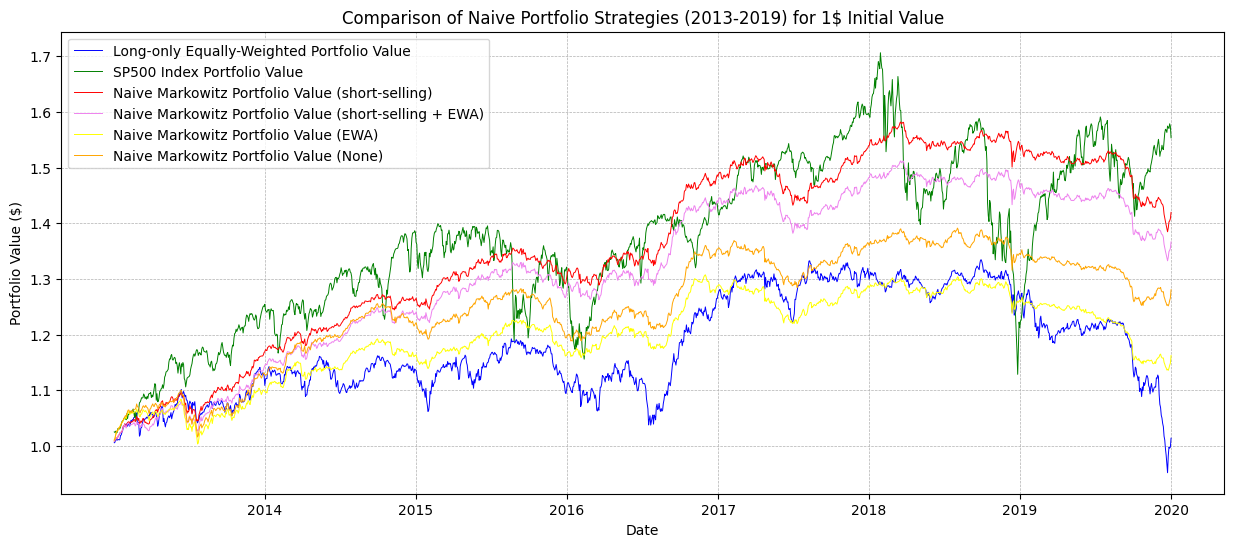

In [19]:
# Generate date range
start_date = '2013-01-01'
end_date = '2019-12-31'
dates = pd.date_range(start=start_date, end=end_date, periods=1510)

# Plot the evolution of the portfolio value
plt.figure(figsize=(15, 6))
plt.plot(dates, p_UNIFORM, color='blue', linestyle='-', linewidth=0.7, label='Long-only Equally-Weighted Portfolio Value')  # Adjust appearance here
plt.plot(dates, p_sp500, color='green', linestyle='-', linewidth=0.7, label='SP500 Index Portfolio Value') 
plt.plot(dates, p_shortselling, color='red', linestyle='-', linewidth=0.7, label='Naive Markowitz Portfolio Value (short-selling)')  
plt.plot(dates, p_shortselling_EWA, color='violet', linestyle='-', linewidth=0.7, label='Naive Markowitz Portfolio Value (short-selling + EWA)')  
plt.plot(dates, p_EWA, color='yellow', linestyle='-', linewidth=0.7, label='Naive Markowitz Portfolio Value (EWA)')  
plt.plot(dates, p, color='orange', linestyle='-', linewidth=0.7, label='Naive Markowitz Portfolio Value (None)')  

plt.title('Comparison of Naive Portfolio Strategies (2013-2019) for 1$ Initial Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Customize x-axis ticks and labels
plt.xticks(pd.date_range(start=start_date, end=end_date, freq='Y'), range(2014, 2021))

plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enable grid with dashed lines
plt.show()

In [124]:
year = '2013-2019'
clustering_method = 'naive'

## process.save_to_csv(year=year, clustering_method=clustering_method)

portfolio_naive = pd.DataFrame(portfolio_value, columns=['PnL'])

portfolio_naive.to_csv(f'PnL_{year}_{clustering_method}_UNIFORM.csv', index=False)

portfolio_mark = pd.DataFrame(portfolio_value_m, columns=['PnL'])

portfolio_mark.to_csv(f'PnL_{year}_{clustering_method}_shortselling.csv', index=False)

portfolio_sp500 = pd.DataFrame(portfolio_value_sp500, columns=['PnL'])

portfolio_sp500.to_csv(f'PnL_{year}_{clustering_method}_sp500.csv', index=False)

In [13]:
year = '2013-2019'
clustering_method = 'naive'

portfolio_mark = pd.DataFrame(portfolio_value_m.values, columns=['PnL'])

portfolio_mark.to_csv(f'PnL_{year}_{clustering_method}.csv', index=False)